
# Slide 10 — Static word embeddings (best fit) → PCA → vector graphic

This notebook recreates the two‑panel **Concept algebra** graphic from your **slide 10** using **static word embeddings** (the most fitting choice for single words):

- `word2vec-google-news-300` (classic, very good geometry — heavy download ~1.5 GB)
- `glove-wiki-gigaword-300` (lighter, good)
- `fasttext-wiki-news-subwords-300` (OOV‑robust via subwords)

It then:
1) projects with **PCA** to 2D, 
2) **rotates** the plane so **KING→QUEEN** points roughly up‑right (stable look),
3) **repels** labels to avoid collisions,
4) draws **arrows after** repel so the vectors connect the *final* label positions,
5) saves **PDF** and **SVG** (vector).

*Tip:* Use `word2vec-google-news-300` for the nicest “analogy” aesthetic if you can afford the download. Otherwise use GloVe‑300.


In [1]:

# If needed:
%pip install gensim matplotlib adjustText scikit-learn --quiet


Note: you may need to restart the kernel to use updated packages.


In [3]:

import os, math, numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
from adjustText import adjust_text

WORDS = ["KING","QUEEN","MAN","WOMAN","UNCLE","AUNT","KINGS","QUEENS"]

# ---------------- Embeddings via gensim ----------------
def embed_gensim(words, model_name="glove-wiki-gigaword-300"):
    import gensim.downloader as api
    kv = api.load(model_name)
    vecs = []
    for w in words:
        key = w.lower()
        try:
            v = kv.get_vector(key)
        except KeyError:
            # simple plural/singular fallback
            alt = key.rstrip('s')
            try:
                v = kv.get_vector(alt)
            except KeyError:
                # fastText supports OOV; for others, zero vector as last resort
                try:
                    v = kv.get_vector(key)  # one more time (some kvs map uppercase)
                except Exception:
                    v = np.zeros(kv.vector_size, dtype=np.float32)
        vecs.append(v)
    X = np.stack(vecs, axis=0)
    # L2 normalize rows
    X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    return X

# ---------------- PCA + orientation ----------------
def pca_2d(X):
    X = np.asarray(X, dtype=np.float64)
    Xc = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    return Xc @ Vt[:2].T  # [N,2]

def normalize_coords(X, pad=0.12):
    X = np.asarray(X, dtype=float)
    minx, miny = X[:,0].min(), X[:,1].min()
    maxx, maxy = X[:,0].max(), X[:,1].max()
    w, h = (maxx - minx) + 1e-9, (maxy - miny) + 1e-9
    Xn = np.empty_like(X)
    Xn[:,0] = (X[:,0] - minx) / w
    Xn[:,1] = (X[:,1] - miny) / h
    return pad + Xn * (1 - 2*pad)

def rotate_to_align(X2, a_idx, b_idx, target=(1.0, 0.7)):
    """Rotate 2D points so vector a->b aligns with 'target' direction (roughly up-right).
    'target' is normalized before use."""
    import numpy as np, math
    v = X2[b_idx] - X2[a_idx]
    if np.allclose(v, 0):
        return X2
    v = v / (np.linalg.norm(v) + 1e-9)
    t = np.array(target, dtype=float)
    t = t / (np.linalg.norm(t) + 1e-9)
    # angle from v to t
    ang = math.atan2(v[1], v[0]) - math.atan2(t[1], t[0])
    c, s = math.cos(-ang), math.sin(-ang)
    R = np.array([[c, -s],[s, c]])
    return X2 @ R.T

# ---------------- Drawing ----------------
BLUE = "#346FC1"; RED="#CC3434"; BOX="#87AAC8"
LEFT_RECT=(0.05,0.14,0.48,0.95); RIGHT_RECT=(0.52,0.14,0.95,0.95)

def draw_two_panel_static(positions, words, out_path, title="", repel=True, fontsize=18, fmt="pdf"):
    fig = plt.figure(figsize=(12.5, 5.4), dpi=220)
    ax = fig.add_axes([0,0,1,1]); ax.set_anchor("C"); ax.set_xlim(0,1); ax.set_ylim(0,1); ax.axis("off"); ax.margins(0.02)
    for rect in (LEFT_RECT, RIGHT_RECT):
        ax.add_patch(Rectangle((rect[0], rect[1]), rect[2]-rect[0], rect[3]-rect[1], fill=False, ec=BOX, lw=2.5))

    def to_panel(p, rect):
        return (rect[0] + p[0]*(rect[2]-rect[0]), rect[1] + p[1]*(rect[3]-rect[1]))

    w2xy = {w: positions[i] for i,w in enumerate(words)}
    L = ["KING","QUEEN","MAN","WOMAN","UNCLE","AUNT"]
    R = ["KING","QUEEN","KINGS","QUEENS"]

    # Draw labels with white rounded boxes
    left_txts, right_txts = [], []
    for w in L:
        x,y = to_panel(w2xy[w], LEFT_RECT)
        left_txts.append(ax.text(x,y,w,fontsize=fontsize,fontweight="bold",ha="center",va="center",
                                 bbox=dict(facecolor="white",edgecolor="white",boxstyle="round,pad=0.22"), zorder=5))
    for w in R:
        x,y = to_panel(w2xy[w], RIGHT_RECT)
        right_txts.append(ax.text(x,y,w,fontsize=fontsize,fontweight="bold",ha="center",va="center",
                                  bbox=dict(facecolor="white",edgecolor="white",boxstyle="round,pad=0.22"), zorder=5))

    if repel:
        adjust_text(left_txts, ax=ax, only_move={'texts':'xy'}, autoalign='y', expand_text=(1.02,1.10))
        adjust_text(right_txts, ax=ax, only_move={'texts':'xy'}, autoalign='y', expand_text=(1.02,1.10))

    # Use final text positions for arrows
    def pos_dict(txts): return {t.get_text(): t.get_position() for t in txts}
    Lpos, Rpos = pos_dict(left_txts), pos_dict(right_txts)

    def arr(a, b, color):
        # Clear, modern arrow: thicker line, larger head, not clipped, above frames but below labels.
        ax.add_patch(FancyArrowPatch(
            a, b,
            arrowstyle="-|>",
            mutation_scale=18,   # head size
            lw=3.2,              # line thickness
            color=color,         # keep caller-provided color
            zorder=4,            # above panel boxes (z~1-2), below text (z=5)
            shrinkA=14,          # keep arrow tips clear of label boxes
            shrinkB=14,
            clip_on=False
        ))

        # left: gender
        arr(Lpos["KING"], Lpos["QUEEN"], BLUE)
        arr(Lpos["MAN"],  Lpos["WOMAN"], BLUE)
        arr(Lpos["UNCLE"],Lpos["AUNT"],  BLUE)
        # right: gender + plural
        arr(Rpos["KING"],  Rpos["QUEEN"], BLUE)
        arr(Rpos["KING"],  Rpos["KINGS"], RED)
        arr(Rpos["QUEEN"], Rpos["QUEENS"], RED)

        if title:
            ax.text(0.5, 0.05, title, ha="center", va="center", fontsize=14)

        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        fig.savefig(out_path, format=fmt, bbox_inches="tight")
        plt.show()
        plt.close(fig)
        return out_path

print("Helpers loaded.")


Helpers loaded.


Saved: assets/outputs/slide10_static_word2vecgooglenews300.pdf
Saved: assets/outputs/slide10_static_word2vecgooglenews300.svg


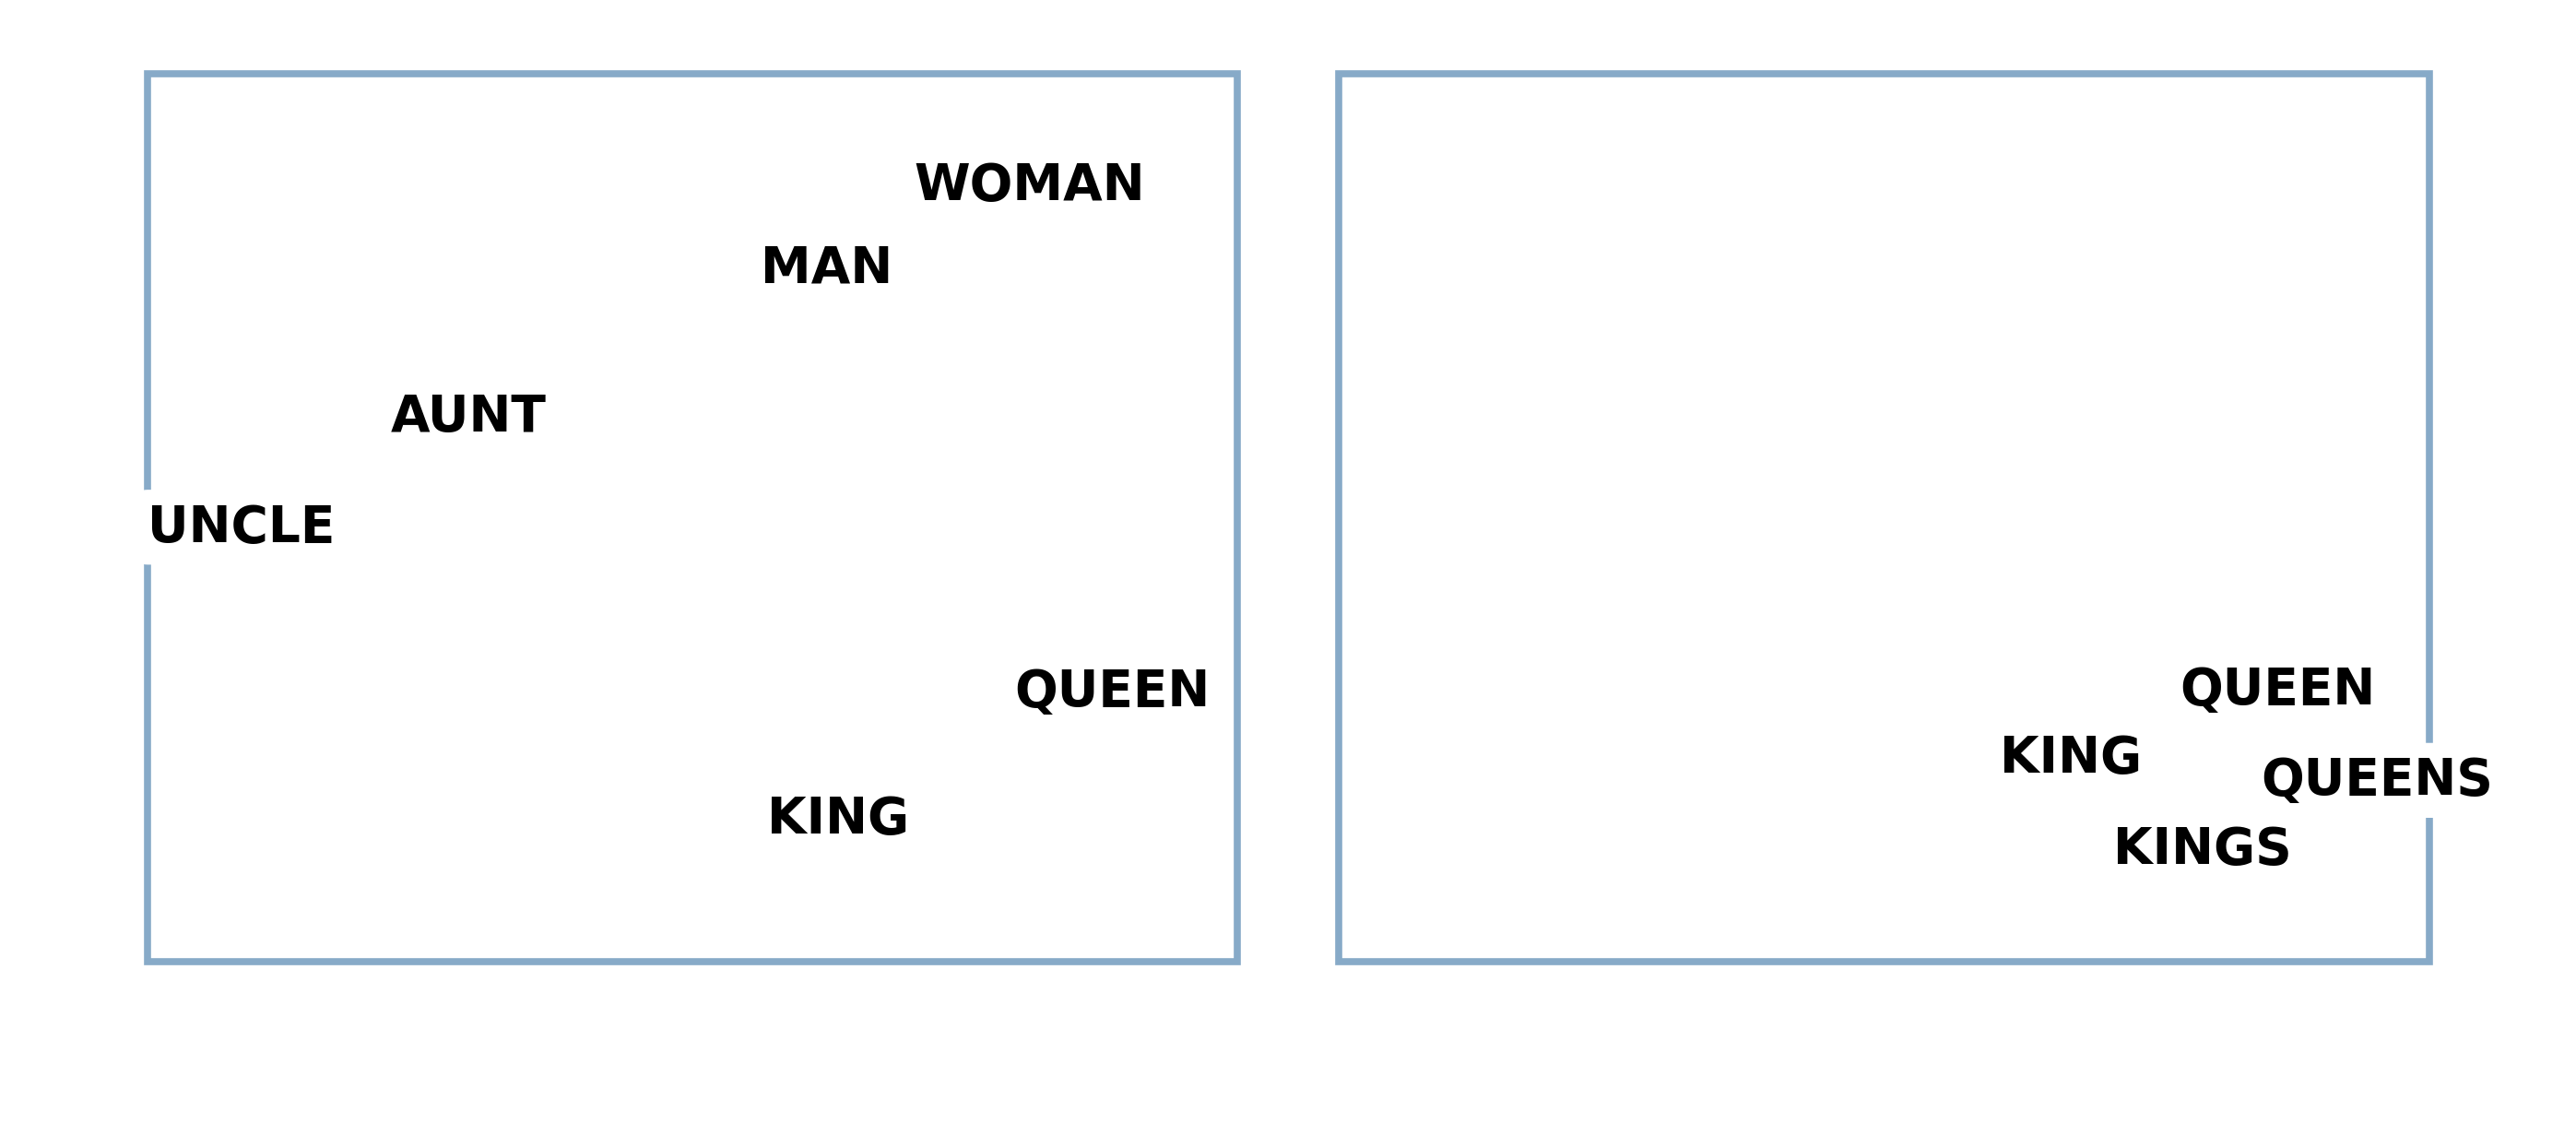

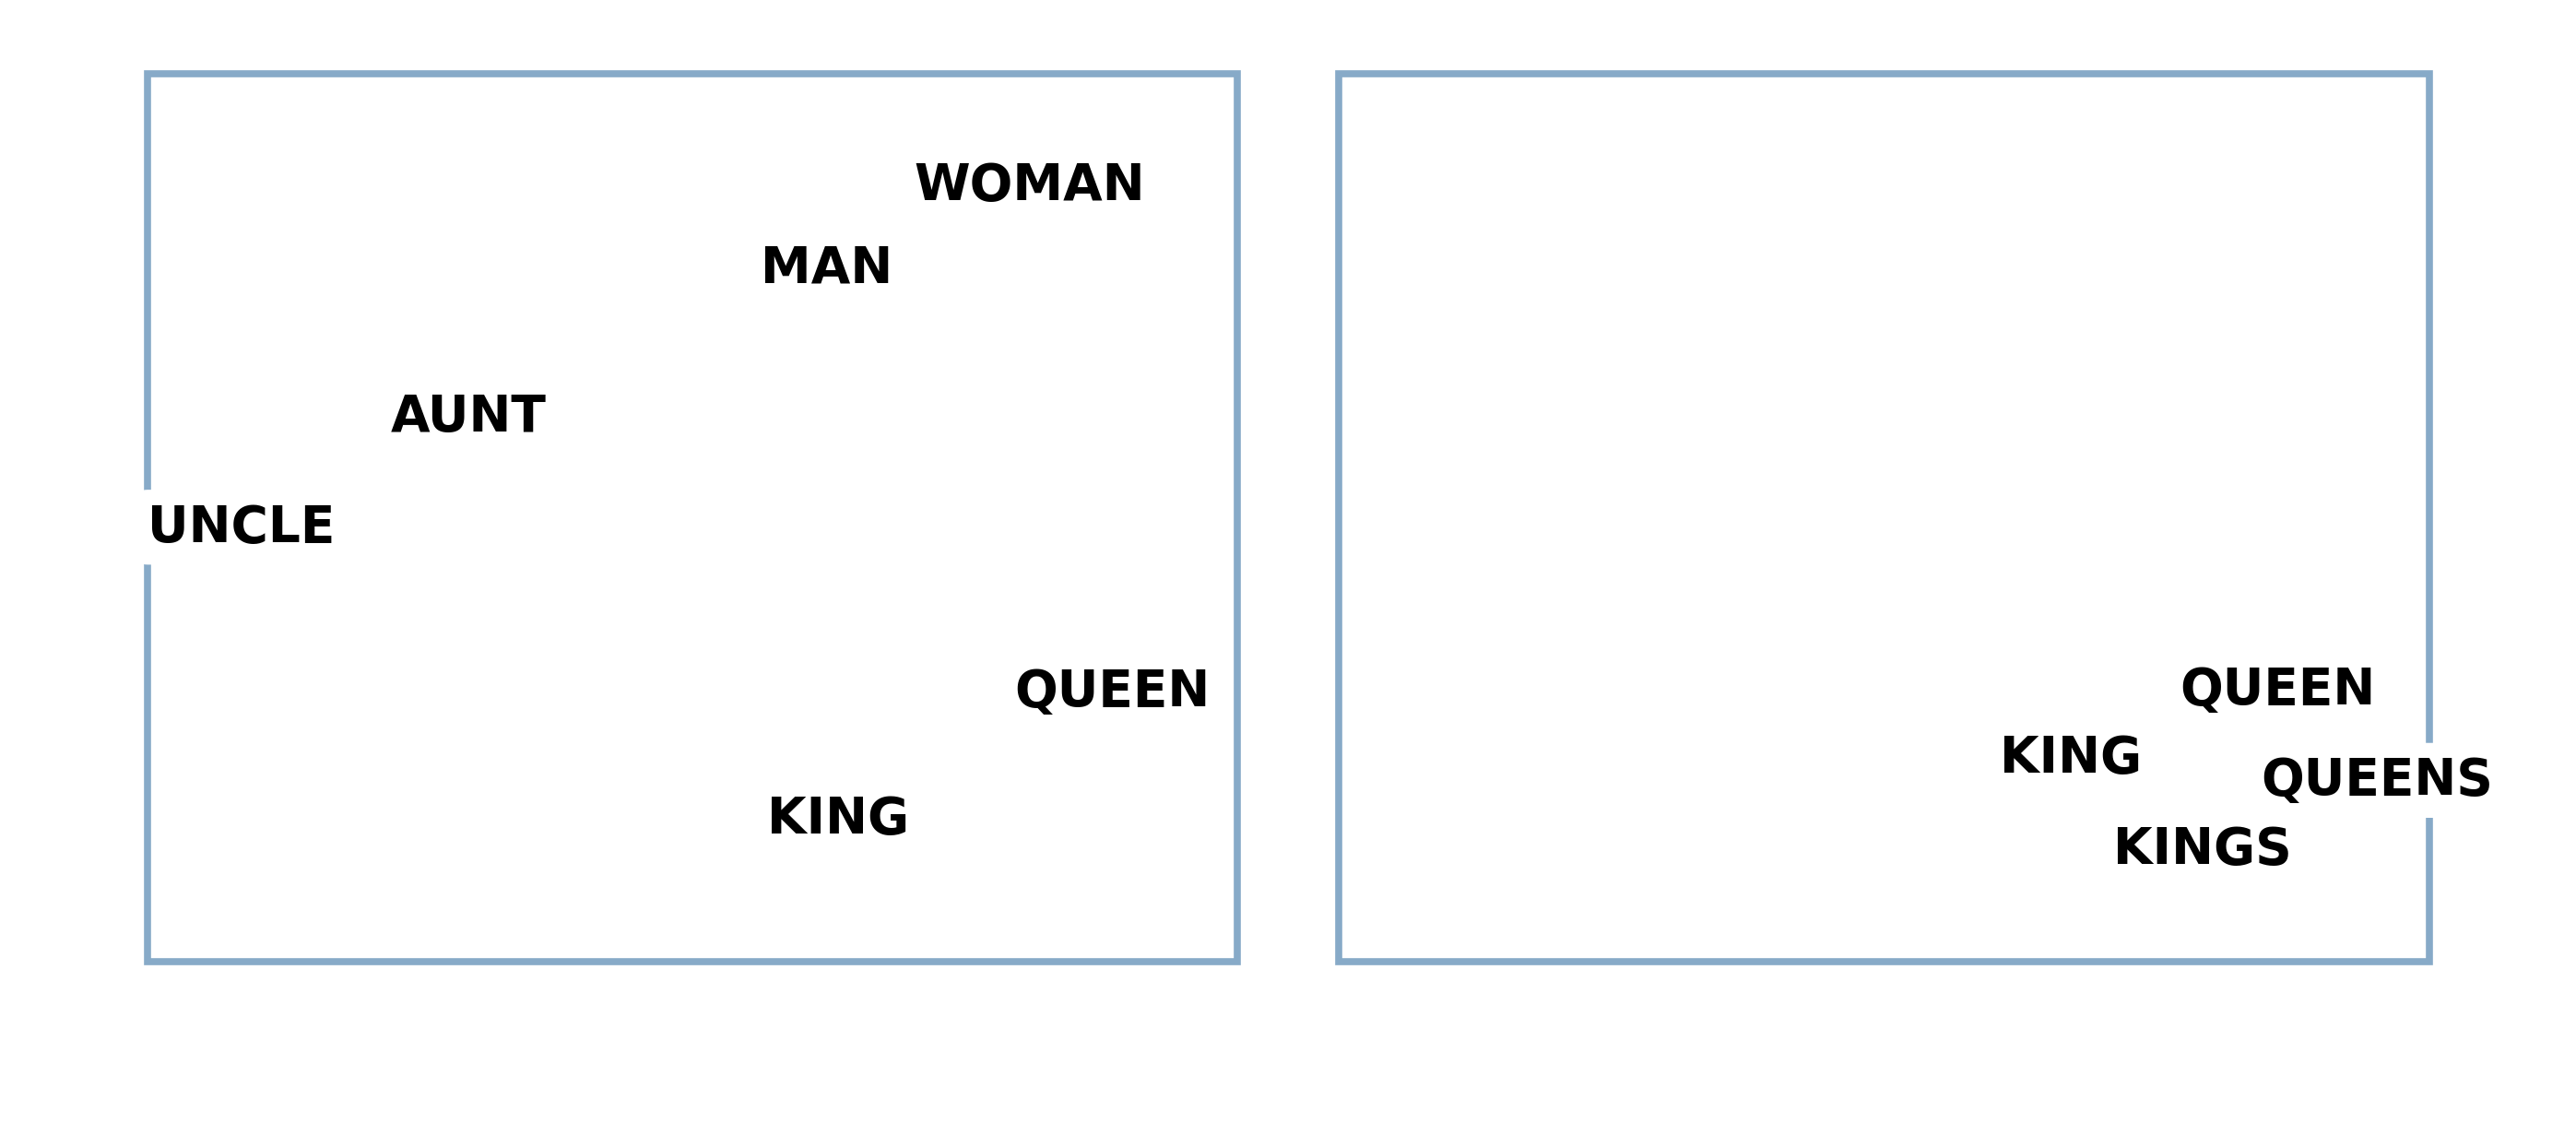

In [4]:

# --- Choose a static model ---
MODEL_NAME = "glove-wiki-gigaword-300"  # good + moderate size
MODEL_NAME = "word2vec-google-news-300"  # best geometry, very large
# MODEL_NAME = "fasttext-wiki-news-subwords-300"  # robust to OOV

X = embed_gensim(WORDS, model_name=MODEL_NAME)

# PCA to 2D
Y = pca_2d(X)

# Rotate so KING->QUEEN points up-right (stable look)
idx = {w:i for i,w in enumerate(WORDS)}
Yr = rotate_to_align(Y, idx["KING"], idx["QUEEN"], target=(1.0, 0.7))

# Normalize to [pad,1-pad]^2 for panel placement
Yn = normalize_coords(Yr, pad=0.16)

# Export PDF + SVG (vector)
base = os.path.join("assets/outputs", f"slide10_static_{MODEL_NAME.replace('-', '').replace(' ', '')}")
pdf = base + ".pdf"; svg = base + ".svg"
draw_two_panel_static(Yn, WORDS, pdf, title=MODEL_NAME, fmt="pdf")
draw_two_panel_static(Yn, WORDS, svg, title=MODEL_NAME, fmt="svg")

print("Saved:", pdf)
print("Saved:", svg)
